In [9]:
# === F1 Fastest Lap: clean delta model (no leakage, robust column handling) ===
from pathlib import Path
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# -----------------------------
# Locate project root & dataset
# -----------------------------
ROOT = Path.cwd()
if ROOT.name.lower() == "notebooks":
    ROOT = ROOT.parent
os.chdir(ROOT)

candidates = [
    ROOT / "outputs" / "f1_features_weather_enhanced.csv",
    ROOT / "outputs" / "f1_features_weather.csv",
]
for p in candidates:
    if p.exists():
        DATA = p
        break
else:
    raise FileNotFoundError("Could not find dataset in outputs/ "
                            "(expected f1_features_weather_enhanced.csv or f1_features_weather.csv)")

df = pd.read_csv(DATA)
print(f"Loaded: {DATA.name}  |  Rows: {len(df)}  |  Cols: {len(df.columns)}")

# -------------------------------------------
# Ensure target exists: delta_s (gap to fastest)
# -------------------------------------------
if "delta_s" not in df.columns:
    if {"bestLaps_s", "raceId"}.issubset(df.columns):
        df["delta_s"] = df["bestLaps_s"] - df.groupby("raceId")["bestLaps_s"].transform("min")
        print("Computed delta_s from bestLaps_s per race.")
    else:
        raise ValueError("Target 'delta_s' missing and cannot be computed "
                         "(need 'bestLaps_s' and 'raceId').")

# -------------------------
# Remove clear leakage cols
# -------------------------
leakage_cols = [
    "finish_pos",       # post-race outcome
    "bestLap_ms",       # raw ms, highly correlated with target
    "bestLaps_s",       # absolute best lap -> we predict gap derived from it
    "f1_rank",          # post-race ranking
    "f1_avg_speed_kph", # post-race aggregate
]
to_drop_leak = [c for c in leakage_cols if c in df.columns]
if to_drop_leak:
    df = df.drop(columns=to_drop_leak)
    print("Removed leakage columns:", to_drop_leak)
else:
    print("Removed leakage columns: []")

# --------------------------------------------------
# Drop friendly-name / label columns (pure text labels)
# (We already have numeric IDs: driverId, constructorId, circuitId, etc.)
# --------------------------------------------------
label_text_cols = [
    "drivers_name", "gp_name", "circuit_name", "date", "url",
    "driverRef", "constructorRef"
]
df = df.drop(columns=[c for c in label_text_cols if c in df.columns], errors="ignore")

# -------------------------------------------
# Missing values: fill numeric with medians
# (categoricals handled by OneHotEncoder)
# -------------------------------------------
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# -------------------------------------------
# Build feature lists from dtypes (robust)
# -------------------------------------------
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target from numeric features
if "delta_s" in num_cols:
    num_cols.remove("delta_s")

# Any leftovers (rare) are dropped
leftovers = set(df.columns) - set(cat_cols) - set(num_cols) - {"delta_s"}
if leftovers:
    print("Dropping non-assigned columns:", leftovers)
    df = df.drop(columns=list(leftovers), errors="ignore")

print(f"Final feature sets -> num: {len(num_cols)} | cat: {len(cat_cols)}")

# -------------------------
# Train / Test split
# -------------------------
X = df.drop(columns=["delta_s"])
y = df["delta_s"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -------------------------
# Pipeline: OHE + RandomForest
# -------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[("preprocess", preprocess), ("rf", rf)])
model.fit(X_train, y_train)

# -------------------------
# Evaluate
# -------------------------
y_pred = model.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR²   : {r2:.3f}")
print(f"MAE  : {mae:.3f} s (gap to fastest)")
print(f"RMSE : {rmse:.3f} s (gap to fastest)")

# -------------------------
# Save model
# -------------------------
save_path = ROOT / "models" / "rf_model_delta_clean2.joblib"
save_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(model, save_path)
print("\n✅ Saved model ->", save_path)


Loaded: f1_features_weather_enhanced.csv  |  Rows: 11041  |  Cols: 34
Computed delta_s from bestLaps_s per race.
Removed leakage columns: ['finish_pos', 'bestLap_ms', 'bestLaps_s']
Final feature sets -> num: 26 | cat: 1

R²   : 0.002
MAE  : 1.436 s (gap to fastest)
RMSE : 7.930 s (gap to fastest)

✅ Saved model -> f:\Personal Projects\F1-FastestLap-Predictor\models\rf_model_delta_clean2.joblib


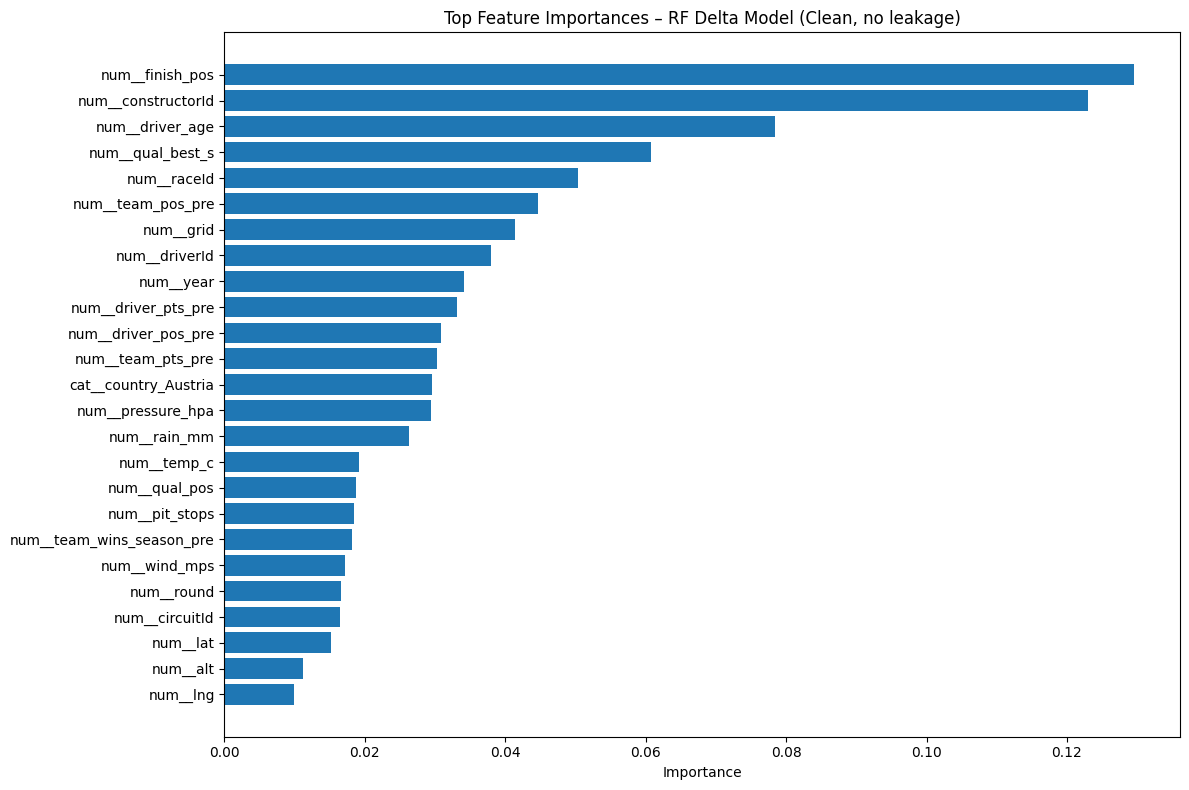

✅ Saved: f:\Personal Projects\F1-FastestLap-Predictor\outputs\feature_importance_delta_clean.png


In [11]:
# === Feature importance for rf_model_delta_clean.joblib ===
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import joblib
from sklearn.pipeline import Pipeline

NB_DIR = Path.cwd()
ROOT = NB_DIR.parent if NB_DIR.name.lower() == "notebooks" else NB_DIR
MODEL_PATH = ROOT / "models" / "rf_model_delta_clean.joblib"
OUT_PLOT = ROOT / "outputs" / "feature_importance_delta_clean.png"

model = joblib.load(MODEL_PATH)

# Extract names robustly from ColumnTransformer
def extract_rf_and_feature_names(model):
    assert isinstance(model, Pipeline), "Expected a Pipeline for the clean model."
    # find ColumnTransformer step (usually called 'pre')
    ct = None
    for name, step in model.named_steps.items():
        if step.__class__.__name__.lower().startswith("columntransformer"):
            ct = step
            break
    if ct is None:
        ct = model.named_steps["pre"]  # fallback if named exactly 'pre'
    rf = model.named_steps.get("rf", None)
    if rf is None:
        # last step is RF
        rf = list(model.named_steps.values())[-1]

    try:
        feat_names = ct.get_feature_names_out()
    except Exception:
        feat_names = []
        for name, trans, cols in ct.transformers_:
            if trans == "drop":
                continue
            if trans == "passthrough":
                feat_names.extend(list(cols))
            else:
                try:
                    feat_names.extend(list(trans.get_feature_names_out(cols)))
                except Exception:
                    feat_names.extend([f"{name}__{c}" for c in cols])
    return rf, list(feat_names)

rf, feature_names = extract_rf_and_feature_names(model)
importances = np.asarray(rf.feature_importances_)
order = np.argsort(importances)[::-1]

topk = 25 if importances.size >= 25 else importances.size
top_names = np.array(feature_names)[order][:topk][::-1]
top_vals  = importances[order][:topk][::-1]

plt.figure(figsize=(12, 8))
plt.barh(top_names, top_vals)
plt.title("Top Feature Importances – RF Delta Model (Clean, no leakage)")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(OUT_PLOT, dpi=300)
plt.show()

print("✅ Saved:", OUT_PLOT)
